#preprocessing and feature engineering**

In [18]:
import pandas as pd
from datetime import datetime, timedelta
import sqlite3

# Connect to the database
db_path = "/content/drive/MyDrive/ML-AI projects/work_hours_tracker/work-hours-tracker/database/work_hours.db"
conn = sqlite3.connect(db_path)

# Read data from the table
query = "SELECT * FROM work_sessions"
df = pd.read_sql_query(query, conn)

# Convert 'start_time' and 'end_time' to datetime objects
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

# Calculate elapsed time
df['elapsed_time'] = df['end_time'] - df['start_time']

# Extract date from 'start_time' and create a new 'date' column
df['date'] = df['start_time'].dt.date

# Group by 'date' and calculate total elapsed time per day
df_per_day = df.groupby('date')['elapsed_time'].sum().reset_index()

# Ensure all dates between first and last are present
start_date = df_per_day['date'].min()
end_date = df_per_day['date'].max()
all_dates = pd.date_range(start=start_date, end=end_date).date

# Merge with a full date range, filling missing dates with 0 elapsed time
df_full = pd.DataFrame({'date': all_dates})
df_full = df_full.merge(df_per_day, on='date', how='left').fillna({'elapsed_time': pd.Timedelta(seconds=0)})

# Convert timedelta to decimal hours
df_full['elapsed_time_hours'] = df_full['elapsed_time'].dt.total_seconds() / 3600  # Convert seconds to hours

# Calculate cumulative elapsed time in decimal hours
df_full['cumulative_elapsed_time_hours'] = df_full['elapsed_time_hours'].cumsum()

print(df_full.head(29))

#save csv file
save_path = "/content/drive/MyDrive/ML-AI projects/work_hours_tracker/work-hours-tracker/datasets/work_hours_per_day.csv"
df_full.to_csv(save_path, index=False)



          date           elapsed_time  elapsed_time_hours  \
0   2025-02-10 0 days 00:02:41.910000            0.044975   
1   2025-02-11 0 days 01:35:58.966000            1.599713   
2   2025-02-12 0 days 04:24:21.986000            4.406107   
3   2025-02-13        0 days 00:00:00            0.000000   
4   2025-02-14        0 days 00:00:00            0.000000   
5   2025-02-15        0 days 00:00:00            0.000000   
6   2025-02-16        0 days 00:00:00            0.000000   
7   2025-02-17        0 days 00:00:00            0.000000   
8   2025-02-18 0 days 00:55:33.444000            0.925957   
9   2025-02-19        0 days 00:00:00            0.000000   
10  2025-02-20        0 days 00:00:00            0.000000   
11  2025-02-21        0 days 00:00:00            0.000000   
12  2025-02-22        0 days 00:00:00            0.000000   
13  2025-02-23        0 days 00:00:00            0.000000   
14  2025-02-24        0 days 00:00:00            0.000000   
15  2025-02-25        0 

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load dataset
df_path = "/content/drive/MyDrive/ML-AI projects/work_hours_tracker/work-hours-tracker/datasets/work_hours_per_day.csv"
df = pd.read_csv(df_path)

# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'])

# Add a column for expected cumulative hours
# Define expected hours (2 hours on weekdays, 4 hours on weekends)
df['weekday'] = df['date'].dt.weekday  # 0=Monday, 6=Sunday
df['expected_hours'] = df['weekday'].apply(lambda x: 2 if x < 5 else 4)  # 2 hours for weekdays, 4 for weekends

# Calculate cumulative expected hours
df['expected_cumulative_hours'] = df['expected_hours'].cumsum()

print(df.head(30))
print(df.describe())

         date            elapsed_time  elapsed_time_hours  \
0  2025-02-10  0 days 00:02:41.910000            0.044975   
1  2025-02-11  0 days 01:35:58.966000            1.599713   
2  2025-02-12  0 days 04:24:21.986000            4.406107   
3  2025-02-13         0 days 00:00:00            0.000000   
4  2025-02-14         0 days 00:00:00            0.000000   
5  2025-02-15         0 days 00:00:00            0.000000   
6  2025-02-16         0 days 00:00:00            0.000000   
7  2025-02-17         0 days 00:00:00            0.000000   
8  2025-02-18  0 days 00:55:33.444000            0.925957   
9  2025-02-19         0 days 00:00:00            0.000000   
10 2025-02-20         0 days 00:00:00            0.000000   
11 2025-02-21         0 days 00:00:00            0.000000   
12 2025-02-22         0 days 00:00:00            0.000000   
13 2025-02-23         0 days 00:00:00            0.000000   
14 2025-02-24         0 days 00:00:00            0.000000   
15 2025-02-25         0 

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib as jb

df_pp=df.copy()
# Feature extraction from 'date'
df_pp['day_of_month'] = df_pp['date'].dt.day
df_pp['month'] = df_pp['date'].dt.month
df_pp['year'] = df_pp['date'].dt.year


# Drop the 'date' column as we won't need it in the model (we already extracted features from it)
df_pp = df_pp.drop(columns=['date'])

# Handle any missing values (if present)
df_pp = df_pp.dropna()

# Define features (X) and target variable (y)
X = df_pp[['expected_hours', 'weekday', 'day_of_month', 'month', 'year']]
y = df_pp['elapsed_time_hours']

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling (important for regression models)
scaler = StandardScaler()
scaler_full=StandardScaler()

X_scaled=scaler_full.fit_transform(X)

#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

save_path_scaler='/content/drive/MyDrive/ML-AI projects/work_hours_tracker/work-hours-tracker/models/scaler_random_forest.pkl'
jb.dump(scaler_full,save_path_scaler)

['/content/drive/MyDrive/ML-AI projects/work_hours_tracker/work-hours-tracker/models/scaler_random_forest.pkl']

#random forest reg

##**with feature scaling**

the best r2 is  0.6941010982222312
the optimal number of trees is  20


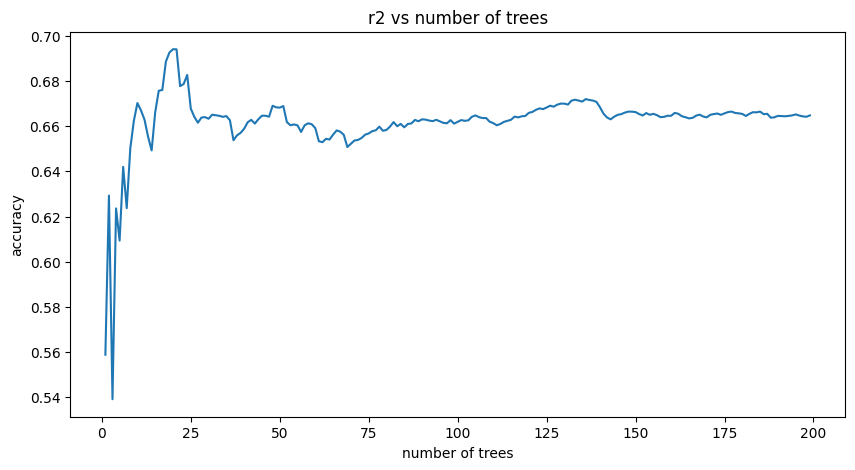

the best mse is  0.7452282001120999
the optimal number of trees is  20


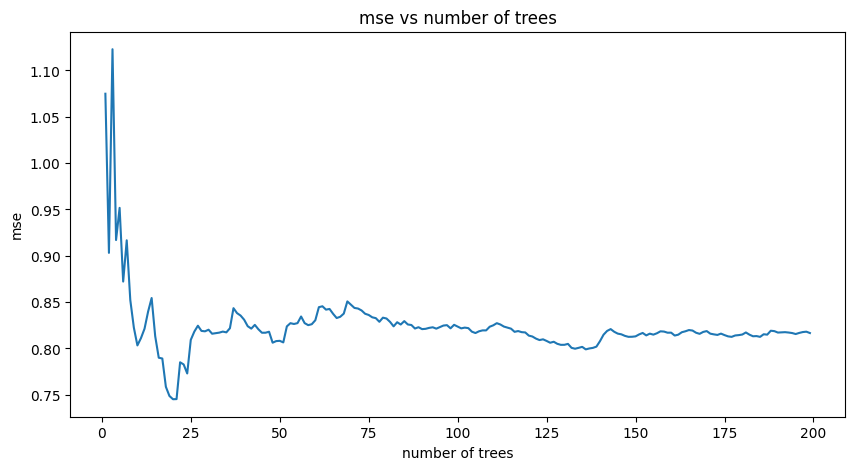

the sum of predictions is =  22.630000000000003  the sum of actaul y is =  21.107669444444447
accuracy =  0.6940990239922452
mse =  0.7452332533328538
[[0.93       0.044975  ]
 [1.31       1.59971278]
 [3.72       4.40610722]
 [0.22       0.        ]
 [0.24       0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.23       0.        ]
 [0.51       0.92595667]
 [0.14       0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.05       0.        ]
 [0.14       0.        ]
 [0.05       0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.55       0.        ]
 [0.55       0.        ]
 [1.84       2.45936139]
 [0.74       0.        ]
 [1.01       1.35906222]
 [0.58       0.        ]
 [3.2        4.82179694]
 [3.2        0.        ]
 [3.42       5.49069722]]


['/content/drive/MyDrive/ML-AI projects/work_hours_tracker/work-hours-tracker/models/random_forest_regression.pkl']

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


#look for the best number of trees

best_accuracy=0
acc_vec=[]
n_vec=[]
threshold=2 # the number of days the model predict / forecast before  the curent date

for i in range(1,200):
  model= RandomForestRegressor(n_estimators=i, random_state=0)
  model.fit(X_scaled[:-threshold],y[:-threshold])
  y_pred= model.predict(X_scaled)
  accuracy=r2_score(y,y_pred)
  if accuracy>best_accuracy:
    best_accuracy=accuracy
    n_optimal=i
  acc_vec.append(accuracy)
  n_vec.append(i)

print("the best r2 is ",best_accuracy)
print("the optimal number of trees is ",n_optimal)
plt.figure(figsize=(10,5))
plt.plot(n_vec,acc_vec)
plt.title("r2 vs number of trees")
plt.xlabel("number of trees")
plt.ylabel("accuracy")
plt.show()

best_accuracy=1000
acc_vec=[]
n_vec=[]
for i in range(1,200):
  model= RandomForestRegressor(n_estimators=i, random_state=0)
  model.fit(X_scaled[:-threshold],y[:-threshold])
  y_pred= model.predict(X_scaled)
  accuracy=mean_squared_error(y,y_pred)
  if accuracy<best_accuracy:
    best_accuracy=accuracy
    n_optimal=i
  acc_vec.append(accuracy)
  n_vec.append(i)

print("the best mse is ",best_accuracy)
print("the optimal number of trees is ",n_optimal)
plt.figure(figsize=(10,5))
plt.plot(n_vec,acc_vec)
plt.title("mse vs number of trees")
plt.xlabel("number of trees")
plt.ylabel("mse")
plt.show()

#save the best model

model= RandomForestRegressor(n_estimators=n_optimal, random_state=0)
model.fit(X_scaled[:-threshold],y[:-threshold])
y_pred= model.predict(X_scaled)
y_pred=np.round(y_pred,2)
print("the sum of predictions is = ",np.sum(y_pred)," the sum of actaul y is = ",np.sum(y))

print("accuracy = ",r2_score(y,y_pred))
print("mse = ",mean_squared_error(y,y_pred))
print(np.concatenate((y_pred.reshape(len(y_pred),1), y.values.reshape(len(y),1)),1))
#save the scaler and the best model

save_path_model='/content/drive/MyDrive/ML-AI projects/work_hours_tracker/work-hours-tracker/models/random_forest_regression.pkl'
jb.dump(model,save_path_model)


#polynomial linear reg

the best r2 is  0.9671548399696358
the optimal number of poly degrees is  5


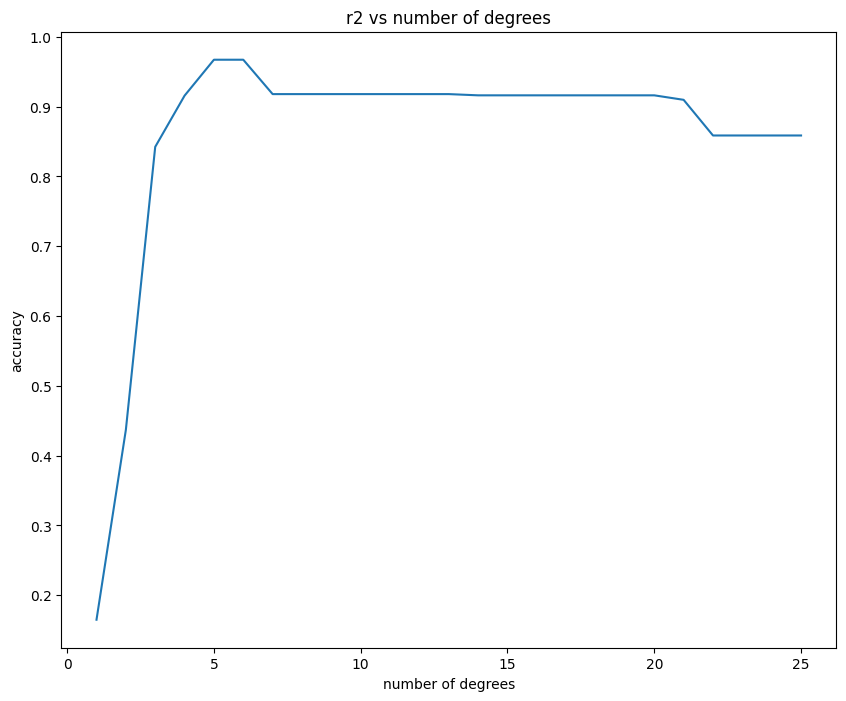

the sum of predictions is =  21.11  the sum of actaul y is =  21.107669444444447
accuracy =  0.8421672421895633
mse =  0.3845107692058698
[[ 0.09        0.044975  ]
 [ 2.38        1.59971278]
 [ 2.48        4.40610722]
 [ 1.31        0.        ]
 [-0.22        0.        ]
 [-0.          0.        ]
 [-0.          0.        ]
 [-0.35        0.        ]
 [ 0.91        0.92595667]
 [ 0.72        0.        ]
 [-0.01        0.        ]
 [-0.35        0.        ]
 [-0.          0.        ]
 [-0.          0.        ]
 [ 0.02        0.        ]
 [ 0.27        0.        ]
 [-0.2         0.        ]
 [-0.47        0.        ]
 [ 0.39        0.        ]
 [-0.          0.        ]
 [ 0.          0.        ]
 [ 2.29        2.45936139]
 [ 0.78        0.        ]
 [ 0.04        1.35906222]
 [ 0.99        0.        ]
 [ 4.55        4.82179694]
 [ 0.          0.        ]
 [ 5.49        5.49069722]]


['/content/drive/MyDrive/ML-AI projects/work_hours_tracker/work-hours-tracker/models/polynomial_features.pkl']

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures



#look for the best number of degrees of the polynom
best_accuracy=0
acc_vec=[]
n_vec=[]

for i in range(1,26):
  pf=PolynomialFeatures(degree=i)
  X_poly=pf.fit_transform(X)
  regressor = LinearRegression()
  regressor.fit(X_poly,y)
  y_pred= regressor.predict(X_poly)
  accuracy=r2_score(y,y_pred)
  if accuracy>best_accuracy:
    best_accuracy=accuracy
    n_optimal=i
  acc_vec.append(accuracy)
  n_vec.append(i)
print("the best r2 is ",best_accuracy)
print("the optimal number of poly degrees is ",n_optimal)
plt.figure(figsize=(10,8))
plt.plot(n_vec,acc_vec)
plt.title("r2 vs number of degrees")
plt.xlabel("number of degrees")
plt.ylabel("accuracy")
plt.show()

#save the best model
pf=PolynomialFeatures(degree=3)
X_poly=pf.fit_transform(X)
regressor = LinearRegression()
regressor.fit(X_poly,y)
y_pred= regressor.predict(X_poly)
y_pred=np.round(y_pred,2)
print("the sum of predictions is = ",np.sum(y_pred)," the sum of actaul y is = ",np.sum(y))

print("accuracy = ",r2_score(y,y_pred))
print("mse = ",mean_squared_error(y,y_pred))
print(np.concatenate((y_pred.reshape(len(y_pred),1), y.values.reshape(len(y),1)),1))

#save the best model
save_path_model='/content/drive/MyDrive/ML-AI projects/work_hours_tracker/work-hours-tracker/models/polynomial_regression.pkl'
save_pf_path='/content/drive/MyDrive/ML-AI projects/work_hours_tracker/work-hours-tracker/models/polynomial_features.pkl'
jb.dump(regressor,save_path_model)
jb.dump(pf,save_pf_path)






#plotting

         date  weekday  expected_hours  expected_cumulative_hours  \
0  2025-02-10        0               2                          2   
1  2025-02-11        1               2                          4   
2  2025-02-12        2               2                          6   
3  2025-02-13        3               2                          8   
4  2025-02-14        4               2                         10   
5  2025-02-15        5               4                         14   
6  2025-02-16        6               4                         18   
7  2025-02-17        0               2                         20   
8  2025-02-18        1               2                         22   
9  2025-02-19        2               2                         24   
10 2025-02-20        3               2                         26   
11 2025-02-21        4               2                         28   
12 2025-02-22        5               4                         32   
13 2025-02-23        6            

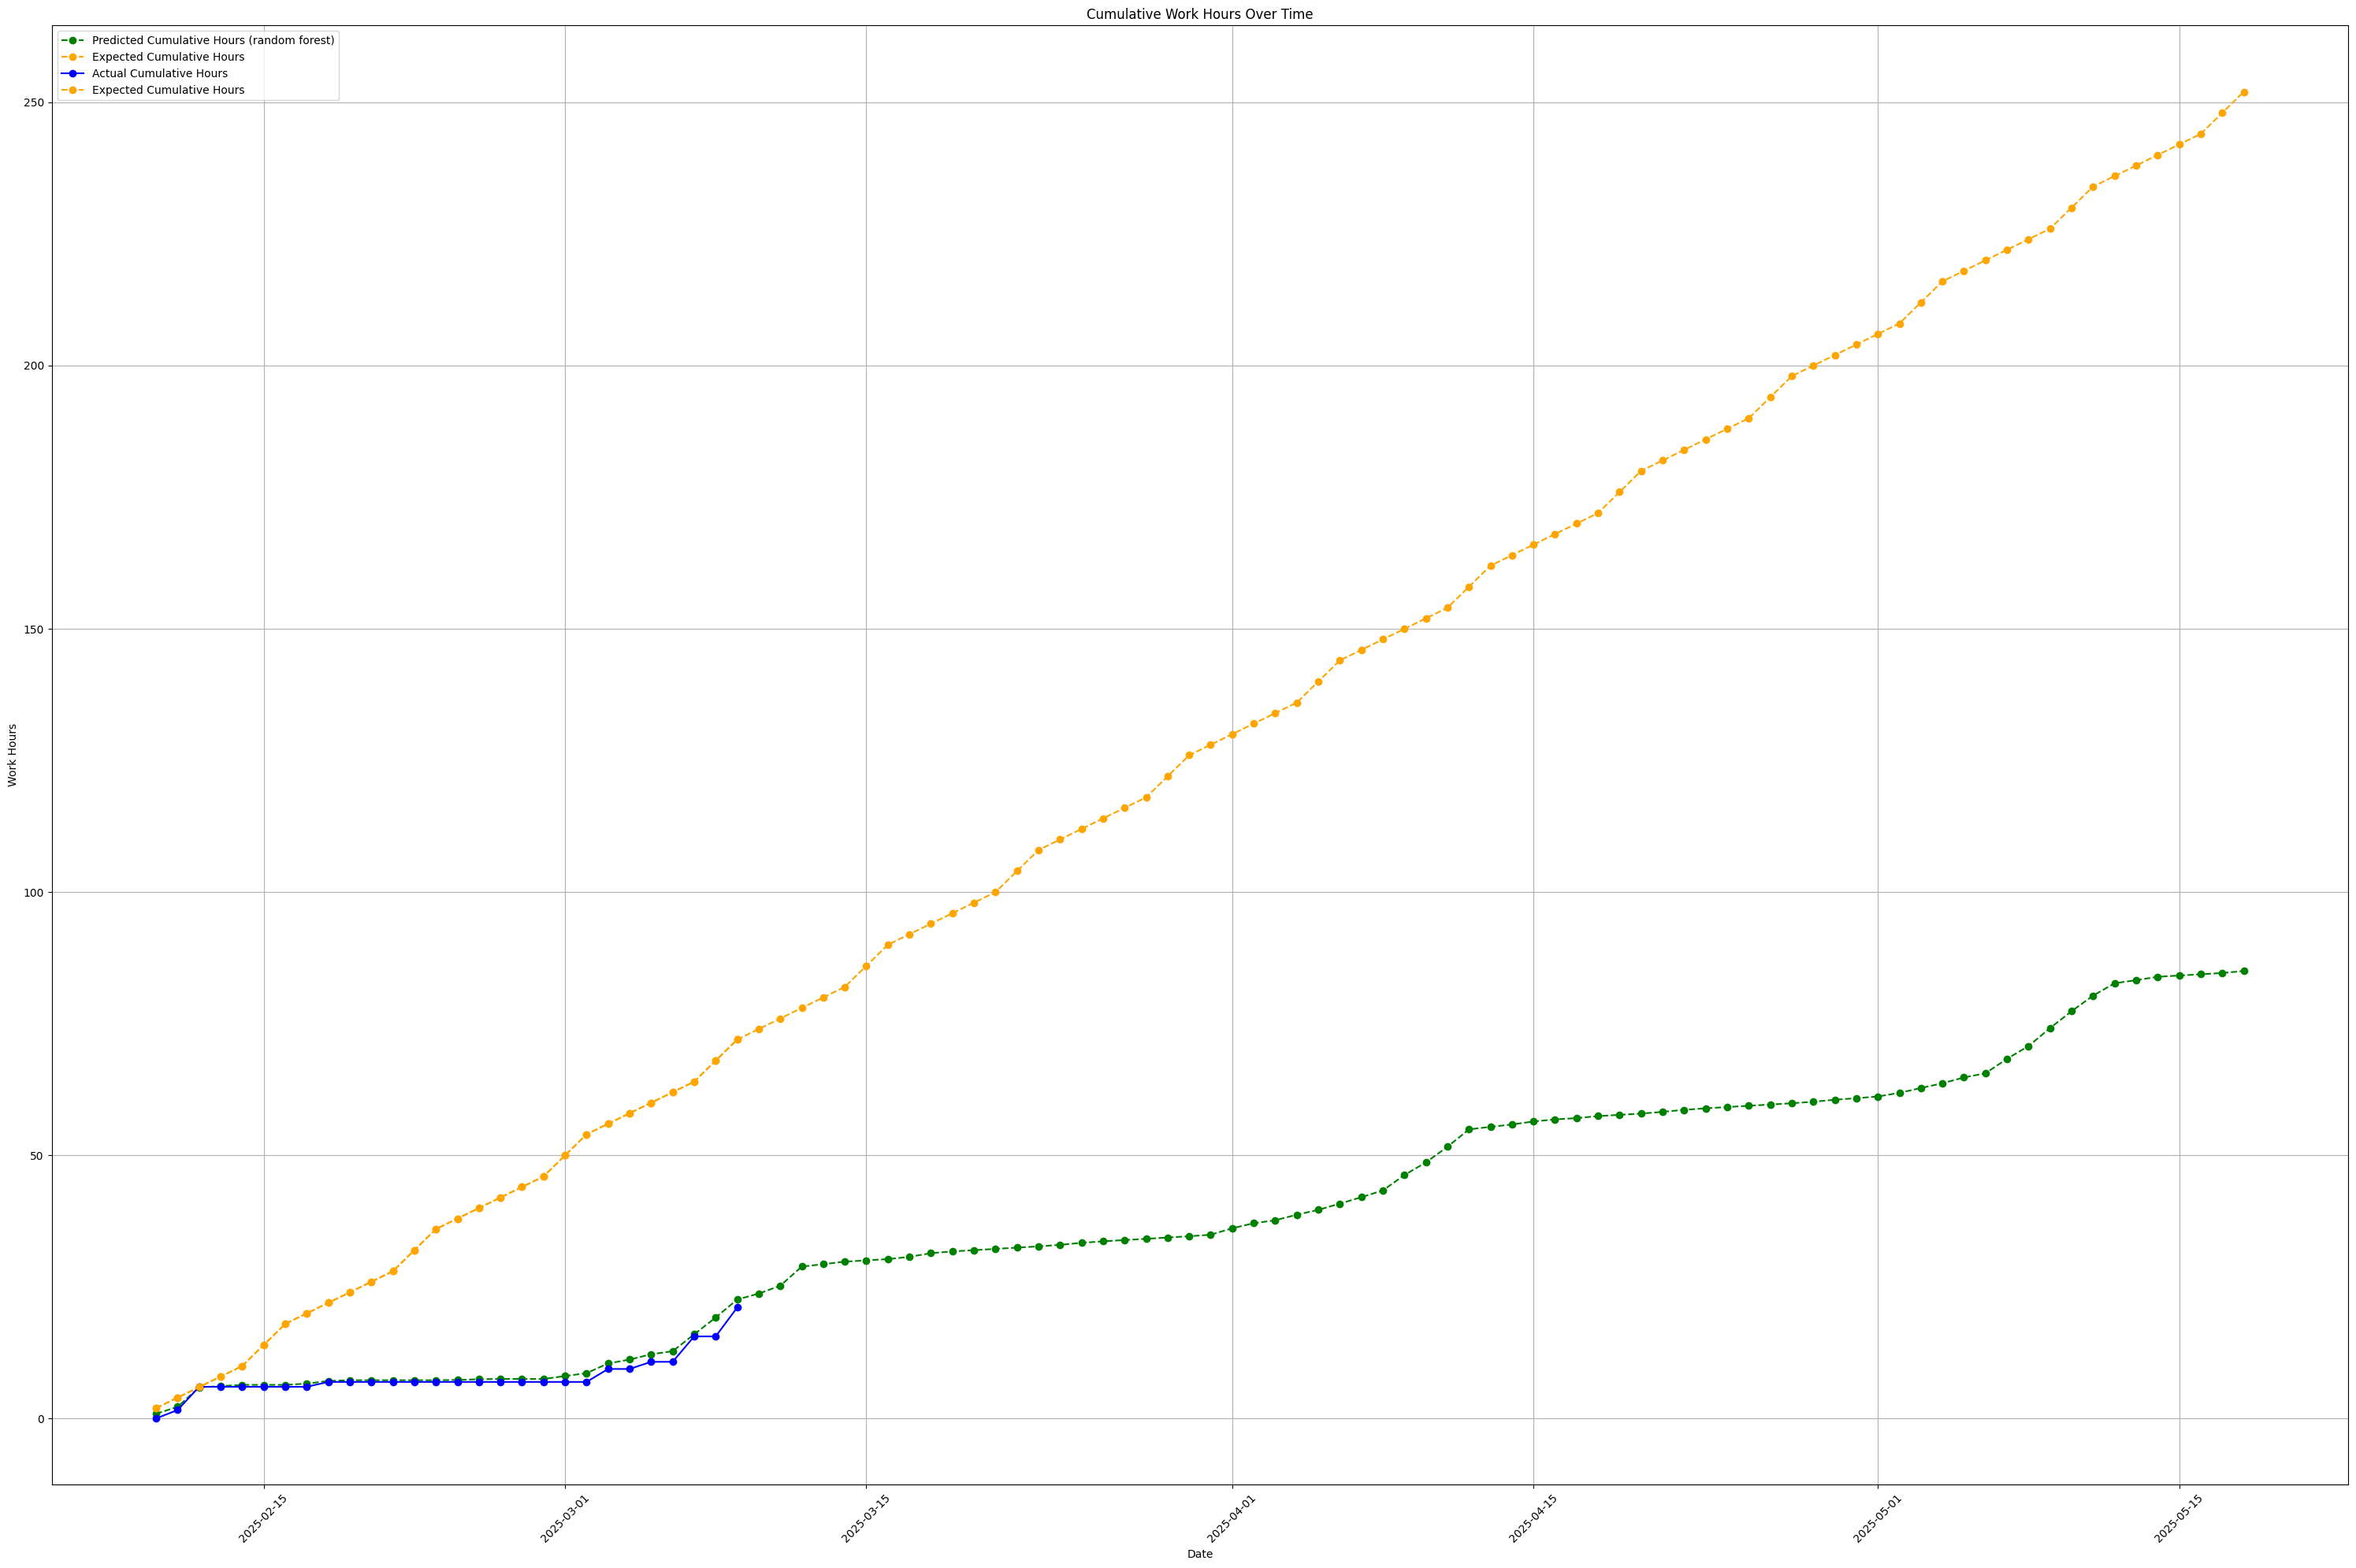

In [25]:

# Plotting

#load the best 2 models
model_path_1= '/content/drive/MyDrive/ML-AI projects/work_hours_tracker/work-hours-tracker/models/polynomial_regression.pkl'
model_path_2= '/content/drive/MyDrive/ML-AI projects/work_hours_tracker/work-hours-tracker/models/random_forest_regression.pkl'
scaler_path= '/content/drive/MyDrive/ML-AI projects/work_hours_tracker/work-hours-tracker/models/scaler_random_forest.pkl'
pf_path = '/content/drive/MyDrive/ML-AI projects/work_hours_tracker/work-hours-tracker/models/polynomial_features.pkl'
model_poly_reg = jb.load(model_path_1)
model_random_reg = jb.load(model_path_2)
scaler=jb.load(scaler_path)
pf=jb.load(pf_path)

#define the forecast period
days_to_forecast = 70

# Calculate the start and end dates for the forecast
start_date_forecast = df_per_day['date'].min()
end_date_forecast = df_per_day['date'].max() + timedelta(days=days_to_forecast)  # Forecast for the next 30 days
all_dates_forecast = pd.date_range(start=start_date_forecast, end=end_date_forecast).date

df_forecast = pd.DataFrame({'date': all_dates_forecast})
# Convert 'date' to datetime
df_forecast['date'] = pd.to_datetime(df_forecast['date'])

# Add a column for expected cumulative hours
# Define expected hours (2 hours on weekdays, 4 hours on weekends)
df_forecast['weekday'] = df_forecast['date'].dt.weekday  # 0=Monday, 6=Sunday
df_forecast['expected_hours'] = df_forecast['weekday'].apply(lambda x: 2 if x < 5 else 4)  # 2 hours for weekdays, 4 for weekends

# Calculate cumulative expected hours
df_forecast['expected_cumulative_hours'] = df_forecast['expected_hours'].cumsum()

# Feature extraction from 'date'
df_forecast['day_of_month'] = df_forecast['date'].dt.day
df_forecast['month'] = df_forecast['date'].dt.month
df_forecast['year'] = df_forecast['date'].dt.year

# Handle any missing values (if present)
#df_forecast = df_pp.dropna()

# Define features (X) and target variable (y)
X_forecast = df_forecast[['expected_hours', 'weekday', 'day_of_month', 'month', 'year']]
X_scaled_forecast=scaler.transform(X_forecast)
X_poly_forecast = pf.transform(X_forecast)

# Make predictions using the loaded model

y_poly_reg =np.round( model_poly_reg.predict(X_poly_forecast),2)
y_rand_forest=np.round(model_random_reg.predict(X_scaled_forecast),2)

df_forecast['predicted_hours_poly_reg'] = y_poly_reg
df_forecast['predicted_hours_random_forest'] = y_rand_forest

#note that the first predicted hour is the last cumulative of the current + the prediction
df_forecast['predicted_cumulative_hours_poly_reg'] = df_forecast['predicted_hours_poly_reg'].cumsum()
df_forecast['predicted_cumulative_hours_random_forest'] = df_forecast['predicted_hours_random_forest'].cumsum()

print(df_forecast.head(40))







plt.figure(figsize=(30, 20))

#plot forecast
#plt.plot(df_forecast['date'], df_forecast['predicted_cumulative_hours_poly_reg'], marker='o', linestyle='-', label='Predicted Cumulative Hours (poly reg)', color='green')
plt.plot(df_forecast['date'], df_forecast['predicted_cumulative_hours_random_forest'], marker='o', linestyle='--', label='Predicted Cumulative Hours (random forest)', color='green')
plt.plot(df_forecast['date'], df_forecast['expected_cumulative_hours'], marker='o', linestyle='--', label='Expected Cumulative Hours', color='orange')

# Plot actual cumulative hours
plt.plot(df['date'], df['cumulative_elapsed_time_hours'], marker='o', linestyle='-', label='Actual Cumulative Hours', color='blue')

# Plot expected cumulative hours
plt.plot(df['date'], df['expected_cumulative_hours'], marker='o', linestyle='--', label='Expected Cumulative Hours', color='orange')

# Dynamic Date Formatting and Ticks
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Dynamic date spacing
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format dates
plt.xticks(rotation=45)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Work Hours')
plt.title('Cumulative Work Hours Over Time')
plt.legend()  # Add legend
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()
